# Running Pipeline with ML Flow tracking server

This notebook demonstrates running through ML pipeline using a local ML Flow tracking server and tensorboard dashboarding.

More Info
* ML Flow tracking https://www.mlflow.org/docs/latest/tracking.html
* Tensorboard https://www.tensorflow.org/tensorboard

## Setting up tracking server

This notebook requires that a ML Flow tracking server b set up. In production, this would be pointing a proper roibust database server and a central storage area for artifacts, but we can demonstrate these concepts using a local machine. 

This notebook works with the `prd_ml` environment, which can be set up from `env/requirements_ml.yml` file. This includes mlflow and tensorboard. ML Flow has two parts to rteacking, a *backend store* and an *artifact store*. The backend store is where metrics, parameter values and paths etc are stored and links to all other elements of a particualr experiment and run. The artifact store is where objects are stored, such as saved trained models or plots. The bacend store will contain references to items in the artifact store related to particular run. The backend store is typically a database of some kind, and the artifact store is file system (e.g. local POSIX) or object store (e.g. cloud storage like AWS S3 or Azure Blob storage).


In this example we will use a local SQL Alchemy database for the backend store and a specified directory on the local filesystem for the artifact store. The backend database is just file, so it also specified as a path. To start up such an ML Flow server, activate the conda environment, then run the following ML Flow command from the command line to start your tracking server

`mlflow server --port $PORT --backend-store-uri sqlite://<PATH TO DB>/<FILENAME>.db  --default-artifact-root $ARTIFACT_PATH`

To Note
* This will only be accessible on your local machine. Yo make more widely accessible use the `--host 0.0.0.0` option
* when specifying the backend URI, if you specify a full path you will need FOUR slashes after the `sqlite:`, for example `sqlite:////user/name/experiments/my_project.db`, otherwise you will get an error.
* The artifact store can be a local file path e.g. `/path/to/artifacts/` or a remote object store like S3 e.g. `s3://project_bucket/project_key/`


In [1]:
import pathlib
import os
import datetime

### Import relevant libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
%load_ext tensorboard

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv1D, concatenate
from tensorflow.keras.layers import ZeroPadding1D, Reshape, Input, Dropout, PReLU
from tensorflow.keras.models import Sequential, Model

from sklearn.metrics import mean_absolute_error, r2_score

In [7]:
import mlflow
mlflow.tensorflow.autolog()

### Load data

In [15]:
prd_root_data_dir = pathlib.Path(os.environ['HOME']) / 'data' / 'precip_rediagnosis'

In [10]:
exp_track_dir = prd_root_data_dir / 'experiments'

In [19]:
prd_dataset_name = 'train_202208'
prd_dataset_dir = prd_root_data_dir / prd_dataset_name
prd_dataset_dir

PosixPath('/Users/stephen.haddad/data/precip_rediagnosis/train_202208')

In [6]:
tensorboard_log_dir = pathlib.Path(os.environ['HOME']) / 'logs' / 'prd'
tensorboard_port = 5002

In [11]:
dt_signature = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
dt_signature

'20220923-094006'

This server is running locally, but to share results, the ML Flow tracking server could be running on a shared server, writing to a shared disk space for the particular project .

In [12]:
mlflow_server_port = 5001
mlflow_server_uri = f'http://127.0.0.1:{mlflow_server_port:d}'
mlflow_server_uri

'http://127.0.0.1:5001'

In [13]:
prd_experiment_name = 'prd_exp_precip_mean'

In [23]:
target_parameter = 'radar_mean_rain_instant'
profile_features = ['air_temperature', 'relative_humidity']
single_lvl_features = ['air_pressure_at_sea_level'] 

### Data pre-processing

In [27]:
import prd_pipeline

AzureML libraries not found, using local execution functions.


In [46]:
import importlib

In [47]:
importlib.reload(prd_pipeline)

AzureML libraries not found, using local execution functions.


<module 'prd_pipeline' from '/Users/stephen.haddad/prog/precip_rediagnosis/model_pipeline/prd_pipeline.py'>

In [48]:
data = prd_pipeline.load_data(prd_dataset_dir)

loading all event data


In [49]:
data

,realization,latitude,longitude,forecast_period,forecast_reference_time,time,cloud_area_fraction,surface_altitude,air_pressure_at_sea_level,rainfall_rate,...,fraction_sum_agg,fraction_sum_instant,radar_fraction_in_band_aggregate_3hr_0.25,radar_fraction_in_band_aggregate_3hr_2.5,radar_fraction_in_band_aggregate_3hr_7.0,radar_fraction_in_band_aggregate_3hr_10.0,radar_fraction_in_band_instant_0.25,radar_fraction_in_band_instant_2.5,radar_fraction_in_band_instant_7.0,radar_fraction_in_band_instant_10.0
0,0,49.40625,-5.484375,0 days 06:00:00,2021-10-19 12:00:00,2021-10-19 18:00:00,1.000000,0.0,100931.0,1.991540,...,1.0,1.007059,0.0,0.0,0.781176,0.218824,0.082353,0.903529,0.021176,0.0
1,1,49.40625,-5.484375,0 days 06:00:00,2021-10-19 12:00:00,2021-10-19 18:00:00,1.000000,0.0,100937.0,2.967194,...,1.0,1.007059,0.0,0.0,0.781176,0.218824,0.082353,0.903529,0.021176,0.0
2,2,49.40625,-5.484375,0 days 06:00:00,2021-10-19 12:00:00,2021-10-19 18:00:00,1.000000,0.0,100959.0,4.050136,...,1.0,1.007059,0.0,0.0,0.781176,0.218824,0.082353,0.903529,0.021176,0.0
3,3,49.40625,-5.484375,0 days 06:00:00,2021-10-19 12:00:00,2021-10-19 18:00:00,1.000000,0.0,101007.0,0.865012,...,1.0,1.007059,0.0,0.0,0.781176,0.218824,0.082353,0.903529,0.021176,0.0
4,4,49.40625,-5.484375,0 days 06:00:00,2021-10-19 12:00:00,2021-10-19 18:00:00,1.000000,0.0,100912.0,2.182648,...,1.0,1.007059,0.0,0.0,0.781176,0.218824,0.082353,0.903529,0.021176,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186979,13,58.78125,1.546875,0 days 06:00:00,2021-10-21,2021-10-21 06:00:00,1.000000,0.0,98909.0,0.000000,...,1.0,1.000000,1.0,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.0
186980,14,58.78125,1.546875,0 days 06:00:00,2021-10-21,2021-10-21 06:00:00,1.000000,0.0,99012.0,0.000000,...,1.0,1.000000,1.0,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.0
186981,15,58.78125,1.546875,0 days 06:00:00,2021-10-21,2021-10-21 06:00:00,0.484375,0.0,98904.0,0.000000,...,1.0,1.000000,1.0,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.0
186982,16,58.78125,1.546875,0 days 06:00:00,2021-10-21,2021-10-21 06:00:00,0.796875,0.0,99010.0,0.000000,...,1.0,1.000000,1.0,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.0


In [50]:
data_dict, data_dims = prd_pipeline.preprocess_data(data,
                                    feature_dict={'profile': profile_features, 
                                                  'single_level': single_lvl_features,
                                                  'target': target_parameter,},
                                    test_fraction=0.2, 
                                   )

target has dims: 23
dropping zeros
getting profile columns
['relative_humidity_5.0', 'relative_humidity_10.0', 'relative_humidity_20.0', 'relative_humidity_30.0', 'relative_humidity_50.0', 'relative_humidity_75.0', 'relative_humidity_100.0', 'relative_humidity_150.0', 'relative_humidity_200.0', 'relative_humidity_250.0', 'relative_humidity_300.0', 'relative_humidity_400.0', 'relative_humidity_500.0', 'relative_humidity_600.0', 'relative_humidity_700.0', 'relative_humidity_800.0', 'relative_humidity_1000.0', 'relative_humidity_1250.0', 'relative_humidity_1500.0', 'relative_humidity_1750.0', 'relative_humidity_2000.0', 'relative_humidity_2250.0', 'relative_humidity_2500.0', 'relative_humidity_2750.0', 'relative_humidity_3000.0', 'relative_humidity_3250.0', 'relative_humidity_3500.0', 'relative_humidity_3750.0', 'relative_humidity_4000.0', 'relative_humidity_4500.0', 'relative_humidity_5000.0', 'relative_humidity_5500.0', 'relative_humidity_6000.0', 'air_temperature_5.0', 'air_temperature

In [51]:
data_dict['X_train']

[array([[[ 1.24325891,  1.11843205],
         [ 1.24325891,  1.14006715],
         [ 1.24296724,  1.16316318],
         ...,
         [ 1.47592207,  1.9011947 ],
         [ 1.46033821,  1.94053243],
         [ 1.45472441,  1.96509956]],
 
        [[ 1.18504777,  1.17038055],
         [ 1.18504777,  1.17454935],
         [ 1.18476393,  1.19728707],
         ...,
         [ 1.45682905,  2.00555854],
         [ 1.38049006,  2.03233474],
         [ 1.39368   ,  2.01120562]],
 
        [[ 1.27236485,  1.20501289],
         [ 1.27236485,  1.20903154],
         [ 1.27206927,  1.23141097],
         ...,
         [ 1.52683656,  1.91279069],
         [ 1.54338038,  1.95200772],
         [ 1.49649157,  2.01120562]],
 
        ...,
 
        [[-2.16209275, -1.04608896],
         [-2.16209275, -1.08403452],
         [-2.16192662, -1.15726158],
         ...,
         [-0.91705935, -2.053035  ],
         [-1.07883421, -2.05286818],
         [-1.33725254, -1.8501776 ]],
 
        [[-1.9365245 , -1.288

In [52]:
data_dims

{'nprof_features': 2, 'nheights': 33, 'nsinglvl_features': 1, 'nbands': 23}

In [53]:
data_dict.keys()

dict_keys(['X_train', 'X_val', 'y_train', 'y_val'])

In [55]:
nprof_features = data_dims['nprof_features']
nheights = data_dims['nheights']
nsinglvl_features = data_dims['nsinglvl_features']

## Set up model and experiment

In [56]:
def build_model(nprof_features, nheights, nsinglvl_features):
    
    profile_input = Input(shape=(nheights, nprof_features), name='profile_input')
    prof_size = nheights*nprof_features

    out = ZeroPadding1D(padding=1)(profile_input)
    out = Conv1D(32, 3, strides=1, activation='relu', use_bias=False, kernel_initializer='glorot_uniform', bias_initializer='zeros')(out)
    ident = out
    out = ZeroPadding1D(padding=1)(out)
    out = Conv1D(32, 3, strides=1, activation='relu', use_bias=False, kernel_initializer='glorot_uniform', bias_initializer='zeros')(out)
    out = ZeroPadding1D(padding=1)(out)
    out = Conv1D(32, 3, strides=1, activation='relu', use_bias=False, kernel_initializer='glorot_uniform', bias_initializer='zeros')(out)
    x = tf.keras.layers.add([out, ident])
    out = Flatten()(x)
    out = Dense(prof_size, use_bias=False, activation='relu')(out)

    if nsinglvl_features > 0:
        surf_input = Input(shape=(nsinglvl_features,), name='surf_input')
        flat_profs = Flatten()(profile_input)
        raw_in = tf.keras.layers.concatenate([flat_profs, surf_input])
        raw_size = (nheights*nprof_features)+nsinglvl_features
        
        out = tf.keras.layers.concatenate([out, surf_input])
        x = tf.keras.layers.add([out, raw_in])
        x = Dense(1024, use_bias=False, activation='relu')(x)
        x = Dense(1024, use_bias=False, activation='relu')(x)
        
        main_output = Dense(1, use_bias=True, activation='linear', name='main_output')(x)
        model = Model(inputs=[profile_input, surf_input], outputs=[main_output])
    
    else:
        main_output = Dense(1, use_bias=True, activation='linear', name='main_output')(out)
        model = Model(inputs=[profile_input], outputs=[main_output])
        
    return model

In [57]:
mlflow.set_tracking_uri(mlflow_server_uri)

In [58]:
try: 
    exp_id = mlflow.create_experiment(prd_experiment_name)
    exp1 = mlflow.get_experiment(exp_id)
except mlflow.exceptions.RestException:
    exp1 = mlflow.get_experiment_by_name(prd_experiment_name)
exp1

<Experiment: artifact_location='/Users/stephen.haddad/data/precip_rediagnosis/experiments/1', experiment_id='1', lifecycle_stage='active', name='prd_exp_precip_mean', tags={}>

### Launch tensorboard to track training
At this point we can start up tensor board to track the training of the model. To track loss function and other metrics during training we will use tensorboard. You can start up the tensorboard server witrh the following command:
```
tensorboard --logdir ${TB_LOG_DIR} --port ${TB_PORT}
```

Alternatively you can run the above as a cell magic command in this jupyter notebook by adding a `%` to the start of the command (see cell below). 

Reference
* [Tensorboard getting started](https://www.tensorflow.org/tensorboard/get_started)


Like ml flow  this should be started from the command line
`tensorboard --logdir <PATH_TO_LOGS>`

The `$TB_LOG_DIR` is the same directory set earlier in the notebook as `tensorboard_log_dir`.

We will set up a callback so that our model traiining info gets sent to tensorboard to view through the server.

In [60]:
tensorflow_callback = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_log_dir, histogram_freq=1)

## Run experiment

Here we actually run the training and evaluation. All parameters and the output model will be saved through ML Flow, and we can track training stats through tensorboard.

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 profile_input (InputLayer)     [(None, 33, 2)]      0           []                               
                                                                                                  
 zero_padding1d_6 (ZeroPadding1  (None, 35, 2)       0           ['profile_input[0][0]']          
 D)                                                                                               
                                                                                                  
 conv1d_6 (Conv1D)              (None, 33, 32)       192         ['zero_padding1d_6[0][0]']       
                                                                                                  
 zero_padding1d_7 (ZeroPadding1  (None, 35, 32)      0           ['conv1d_6[0][0]']         

/Users/stephen.haddad/opt/anaconda3/envs/prd_ml/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


1626/1626 [==============================] - 20s 12ms/step - loss: 16213491704800124571763433537536.0000 - val_loss: 0.4478
INFO:tensorflow:Assets written to: /var/folders/w0/2x361bn95wj7lfgl33vksx1w0000gn/T/tmposcou7nt/model/data/model/assets


2022/09/23 10:28:09 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/stephen.haddad/opt/anaconda3/envs/prd_ml/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument."
2022/09/23 10:28:09 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/stephen.haddad/opt/anaconda3/envs/prd_ml/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument."


MAE: 11961230665341600245939406110720.000
R-squared score: -0.000


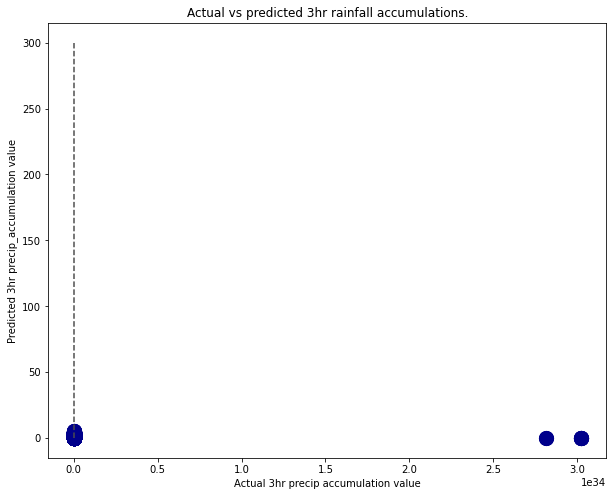

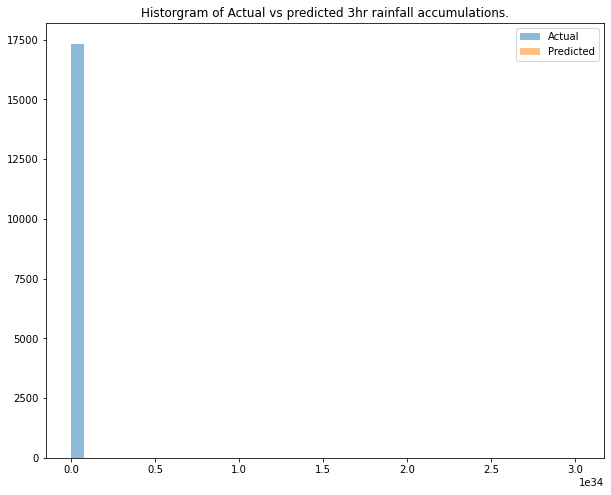

In [63]:
with mlflow.start_run(experiment_id=exp1.experiment_id, run_name='run1') as current_run:
    model = build_model(nprof_features, nheights, nsinglvl_features)
    model.summary()
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='mean_absolute_error', optimizer=optimizer)

    history = model.fit(data_dict['X_train'], 
                        data_dict['y_train'], 
                        epochs=1, 
                        batch_size=32, 
                        validation_split=0.25, 
                        verbose=True, 
                        callbacks=[tensorflow_callback])

    y_pred = model.predict(data_dict['X_val'])
    error = mean_absolute_error(data_dict['y_val'], y_pred)
    print(f'MAE: {error:.3f}')
    rsqrd = r2_score(data_dict['y_val'], y_pred)
    print(f'R-squared score: {rsqrd:.3f}')
    
    mlflow.log_metric('MAE', error)
    mlflow.log_metric('R-squared', rsqrd)
    
    fig1 = plt.figure(figsize=(10, 8))
    ax1 = fig1.add_subplot(1,1,1, title='Actual vs predicted 3hr rainfall accumulations.')
    ax1.scatter(data_dict['y_val'], y_pred, s=200, c='darkblue')
    ax1.plot([0, 300], [0, 300], ls="--", c=".3")
    ax1.set_xlabel('Actual 3hr precip accumulation value')
    ax1.set_ylabel('Predicted 3hr precip_accumulation value')
    mlflow.log_figure(fig1, 'scatter_actual_vs_predicted_3hr_rainfall.png')
    
    fig1 = plt.figure(figsize=(10, 8))
    ax1 = fig1.add_subplot(1,1,1, title='Historgram of Actual vs predicted 3hr rainfall accumulations.')
    ax1.hist(data_dict['y_val'], alpha=0.5, bins=40, label='Actual')
    ax1.hist(y_pred, alpha=0.5, bins=40, label='Predicted')
    ax1.legend()
    mlflow.log_figure(fig1, 'hist_actual_vs_predicted_3hr_rainfall.png')
    
